### Visualization

This jupyter notebook provide some __visualization example__ for checking the result of the chain. Please revise and adapt it based on your own need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

/home/niyashao/miniforge3/envs/geostats/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load compiled bed elevation measurements
df = pd.read_csv('./DenmanDataGridded.csv')

In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [6]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [7]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

### bed

In [58]:
bed = np.loadtxt('Denman_bed_0.txt')

In [59]:
bed2 = np.loadtxt('Denman_bed_300000.txt')

(2200000.0, 2600000.0, -500500.0, -300500.0)

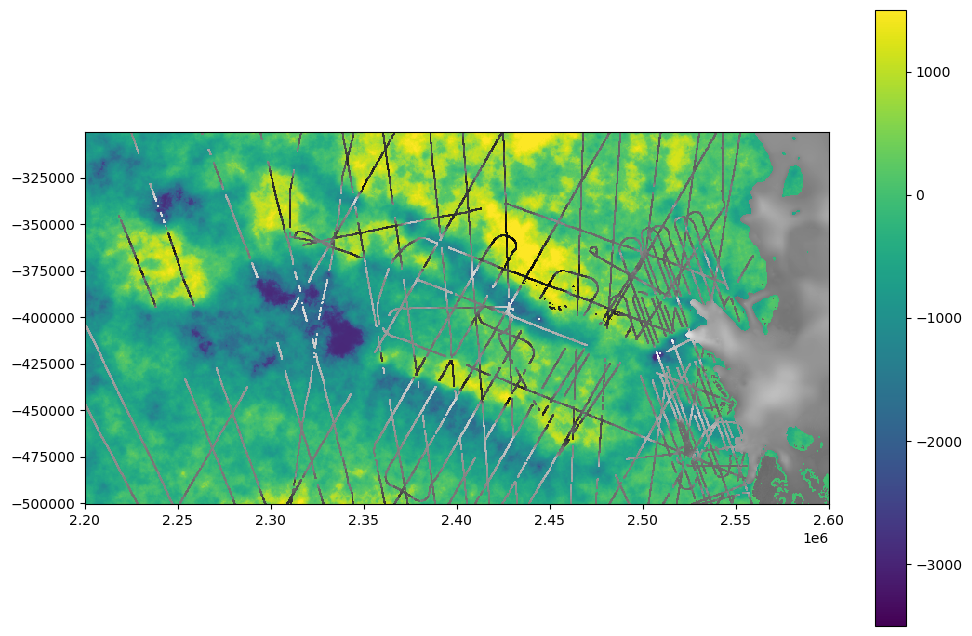

In [62]:
fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed,vmin=-3500,vmax=1500)
plt.colorbar()
plt.pcolormesh(xx,yy,cond_bed,cmap='Greys')
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

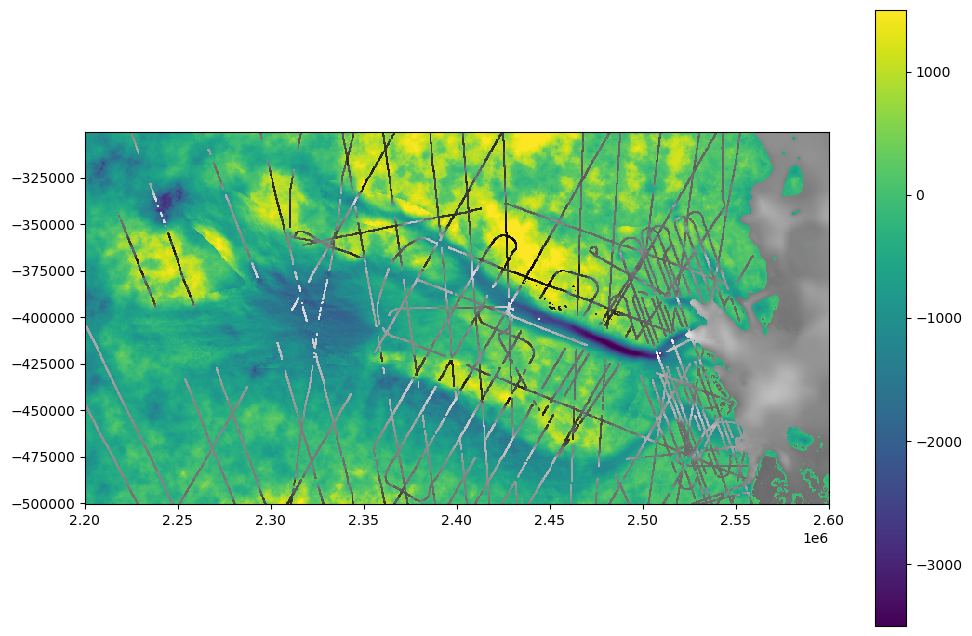

In [63]:
fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2,vmin=-3500,vmax=1500)
plt.colorbar()
plt.pcolormesh(xx,yy,cond_bed,cmap='Greys')
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

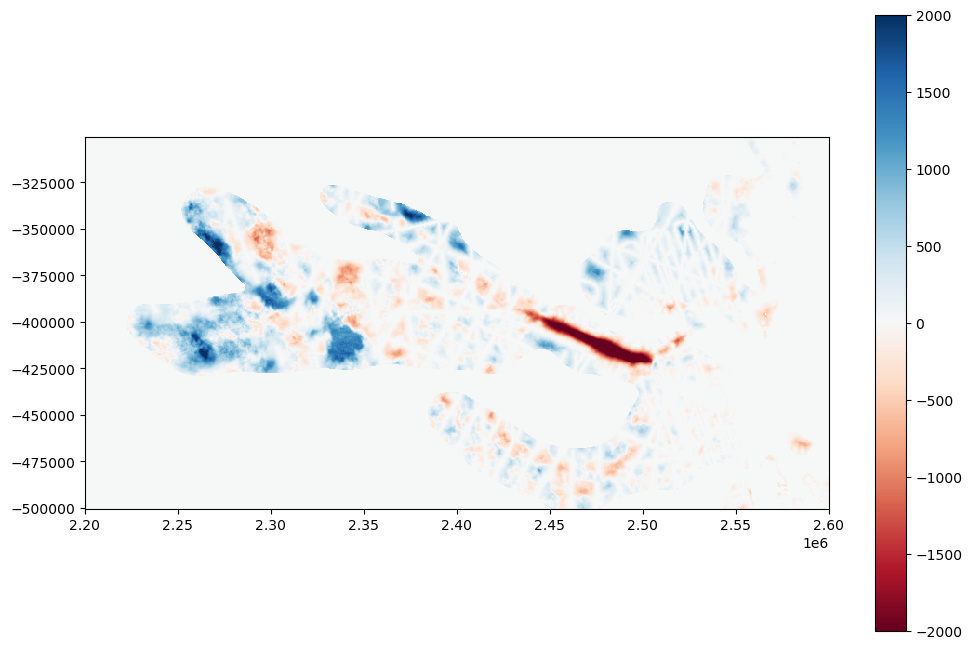

In [65]:
fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2 - bed,cmap='RdBu',vmax=2000,vmin=-2000)
plt.colorbar()
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

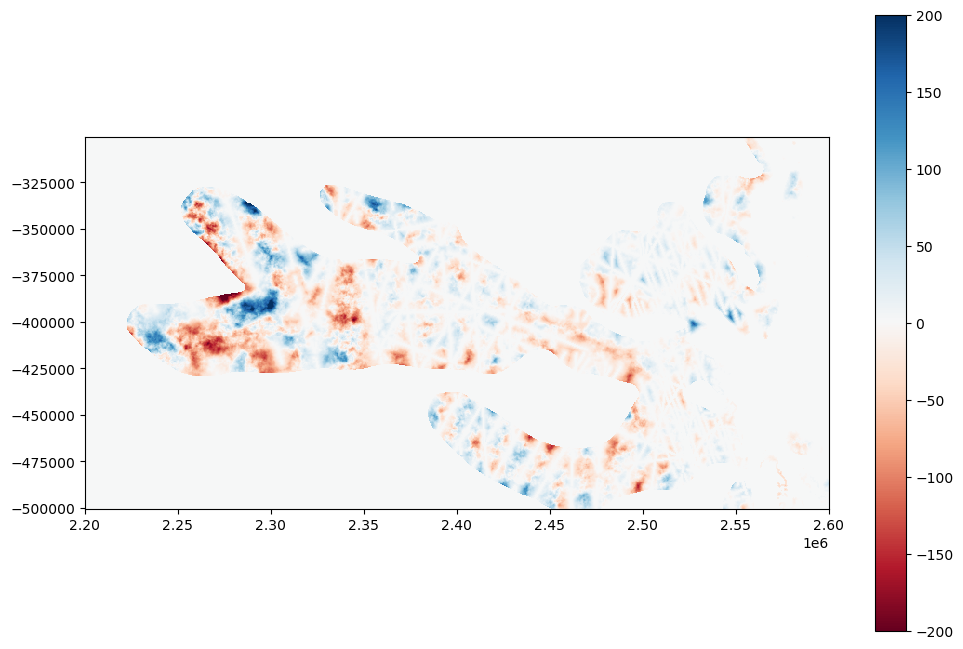

In [86]:
bed2 = np.loadtxt('Denman_bed_210000.txt')
bed1 = np.loadtxt('Denman_bed_200000.txt')

fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2 - bed1,cmap='RdBu',vmax=200,vmin=-200)
plt.colorbar()
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

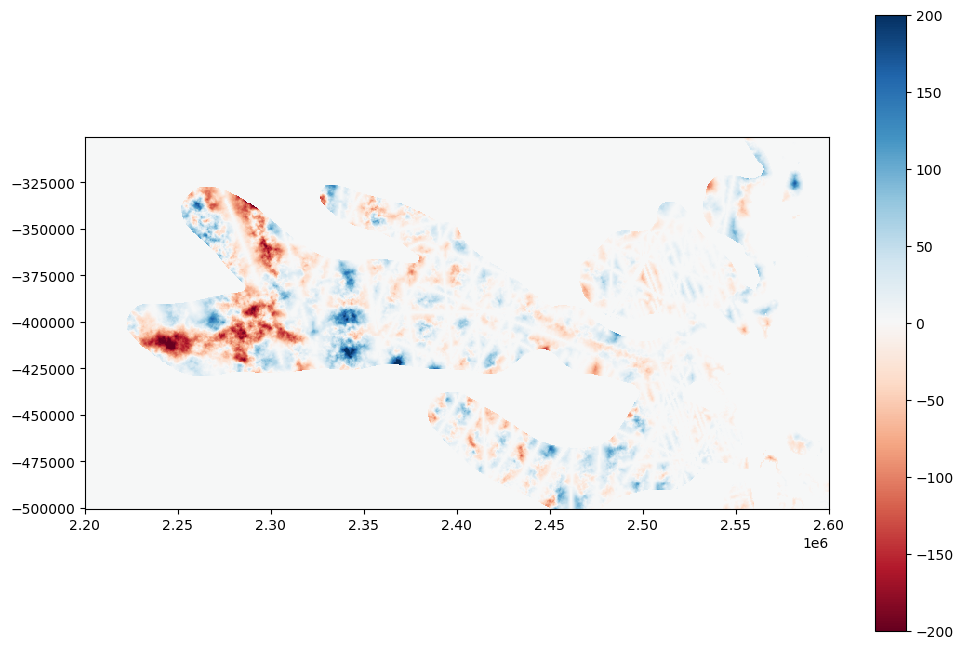

In [87]:
bed2 = np.loadtxt('Denman_bed_220000.txt')
bed1 = np.loadtxt('Denman_bed_210000.txt')

fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2 - bed1,cmap='RdBu',vmax=200,vmin=-200)
plt.colorbar()
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

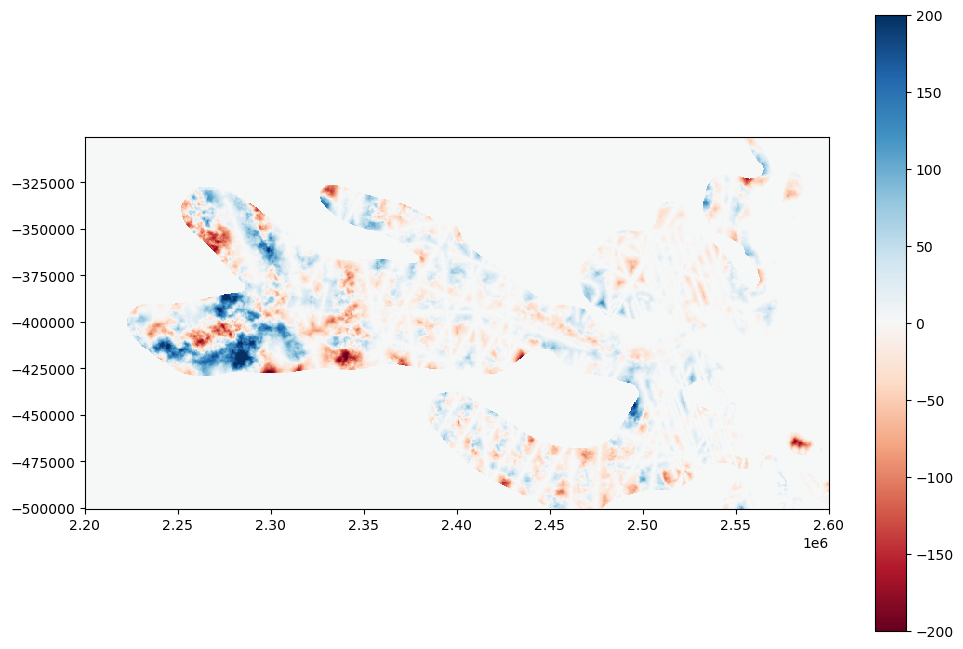

In [88]:
bed2 = np.loadtxt('Denman_bed_230000.txt')
bed1 = np.loadtxt('Denman_bed_220000.txt')

fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2 - bed1,cmap='RdBu',vmax=200,vmin=-200)
plt.colorbar()
plt.axis('scaled')

(2200000.0, 2600000.0, -500500.0, -300500.0)

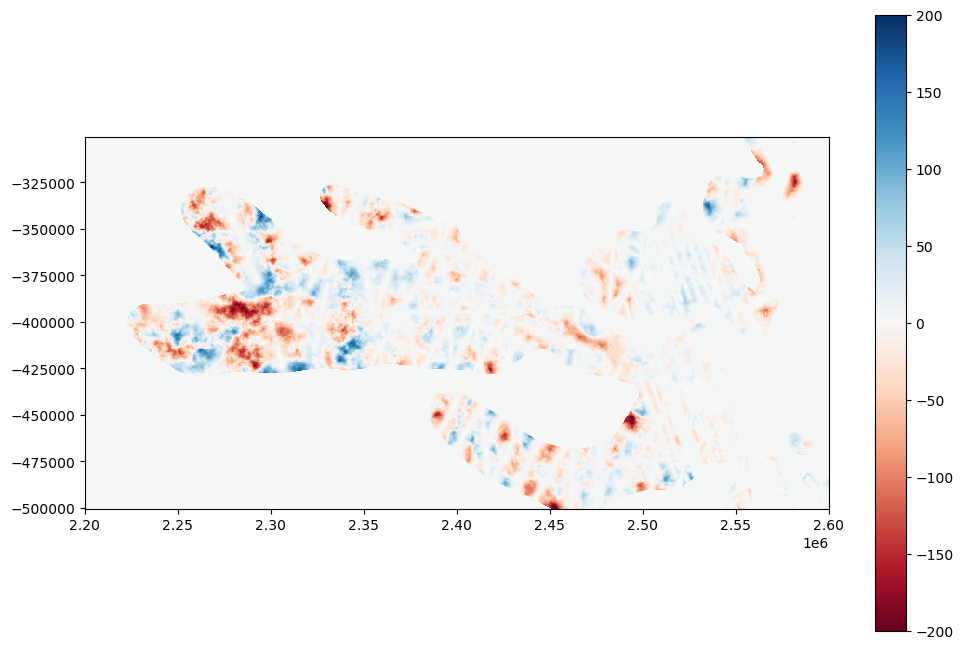

In [89]:
bed2 = np.loadtxt('Denman_bed_240000.txt')
bed1 = np.loadtxt('Denman_bed_230000.txt')

fig = plt.figure(figsize=(12,8))
plt.pcolormesh(xx,yy,bed2 - bed1,cmap='RdBu',vmax=200,vmin=-200)
plt.colorbar()
plt.axis('scaled')

### loss

In [66]:
loss

array([      0.        ,       0.        ,       0.        , ...,
       1124292.22254773, 1124292.14843309, 1124292.14843309])

In [75]:
total_iter = 600000
n_per_file = 1000

loss = np.zeros(total_iter)
steps = np.zeros(total_iter)
for i in range(0,int(total_iter/n_per_file)):
    loss[i*1000:(i+1)*1000] = np.loadtxt('Denman_loss_' + str(i*1000) + '.txt')
    steps[i*1000:(i+1)*1000] = np.loadtxt('Denman_steps_' + str(i*1000) + '.txt')


acceptance_rate = [np.mean(steps[i:i+1000]) for i in range(total_iter - 1000)]

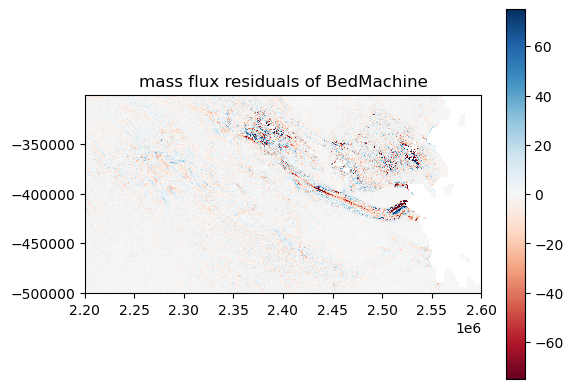

In [76]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mc_res_bm,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of BedMachine')
plt.axis('scaled')
plt.colorbar()

In [77]:
dummy_bed = np.zeros(xx.shape)
grounded_ice_mask = (bedmap_mask == 1)

In [78]:
largeScaleChain = MCMC.chain_crf(xx, yy, dummy_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


In [79]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


In [80]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)

In [81]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_bedmachine

(691498.2810784966, 691498.2810784966, 0.0)

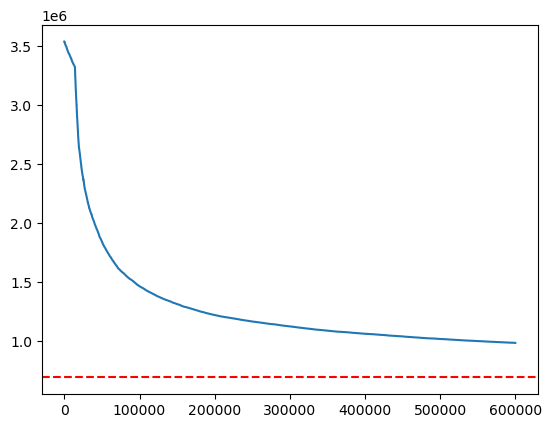

In [82]:
plt.plot(loss)
plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')

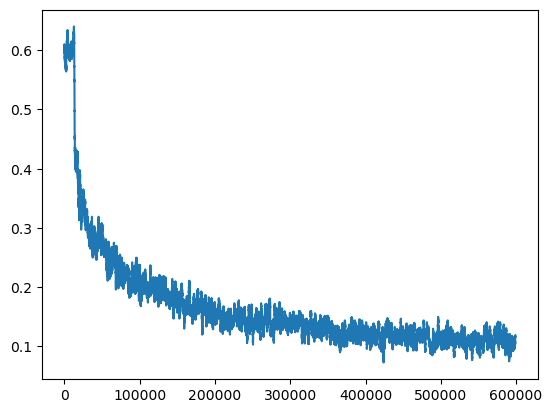

In [83]:
plt.plot(acceptance_rate)